# Simulation (rough notes)


In [1]:
import itertools
from joblib import Parallel, delayed
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.stats import t
import simpy

## Random sampling


In [2]:
# This is essentially our "starter seed"
entropy = 12345

# Generate 10 seeds which will create independent streams
ss = np.random.SeedSequence(entropy)
seeds = ss.spawn(10)

# Initialise RNGs with independent seeds
rng = np.random.default_rng(seeds[0])
rng1 = np.random.default_rng(seeds[1])

# Generate random numbers
print(rng.random(), rng1.random())

0.8699988509120198 0.37707540876459267


## HSMA DES book

The code below is copied from: https://hsma-programme.github.io/hsma6_des_book/an_example_simpy_model.html. That code was shared under an MIT Licence, with credit to: Sammi Rosser and Dan Chalk (2024) HSMA - the little book of DES https://github.com/hsma-programme/hsma6_des_book.

Classes with:

* Parameter values
* Patient characteristics
* Model - inc. generate arrivals, attend clinic, calculate results, run model
* Trial - batch of simulations


In [3]:
# Class to store global parameter values.  We don't create an instance of this
# class - we just refer to the class blueprint itself to access the numbers
# inside.
class g:
    patient_inter = 5
    mean_n_consult_time = 6
    number_of_nurses = 1
    sim_duration = 120
    number_of_runs = 5


# Class representing patients coming in to the clinic.  Here, patients have
# two attributes that they carry with them - their ID, and the amount of time
# they spent queuing for the nurse.  The ID is passed in when a new patient is
# created.
class Patient:
    def __init__(self, p_id):
        self.id = p_id
        self.q_time_nurse = 0


# Class representing our model of the clinic.
class Model:
    # Constructor to set up the model for a run.  We pass in a run number when
    # we create a new model.
    def __init__(self, run_number):
        # Create a SimPy environment in which everything will live
        self.env = simpy.Environment()

        # Create a patient counter (which we'll use as a patient ID)
        self.patient_counter = 0

        # Create a SimPy resource to represent a nurse, that will live in the
        # environment created above.  The number of this resource we have is
        # specified by the capacity, and we grab this value from our g class.
        self.nurse = simpy.Resource(self.env, capacity=g.number_of_nurses)

        # Store the passed in run number
        self.run_number = run_number

        # Create a new Pandas DataFrame that will store some results against
        # the patient ID (which we'll use as the index).
        self.results_df = pd.DataFrame()
        self.results_df["Patient ID"] = [1]
        self.results_df["Q Time Nurse"] = [0.0]
        self.results_df["Time with Nurse"] = [0.0]
        self.results_df.set_index("Patient ID", inplace=True)

        # Create an attribute to store the mean queuing time for the nurse
        # across this run of the model
        self.mean_q_time_nurse = 0

    # A generator function that represents the DES generator for patient
    # arrivals
    def generator_patient_arrivals(self):
        # We use an infinite loop here to keep doing this indefinitely whilst
        # the simulation runs
        while True:
            # Increment the patient counter by 1 (this means our first patient
            # will have an ID of 1)
            self.patient_counter += 1

            # Create a new patient - an instance of the Patient Class we
            # defined above.  Remember, we pass in the ID when creating a
            # patient - so here we pass the patient counter to use as the ID.
            p = Patient(self.patient_counter)

            # Tell SimPy to start up the attend_clinic generator function with
            # this patient (the generator function that will model the
            # patient's journey through the system)
            self.env.process(self.attend_clinic(p))

            # Randomly sample the time to the next patient arriving.  Here, we
            # sample from an exponential distribution (common for inter-arrival
            # times), and pass in a lambda value of 1 / mean.  The mean
            # inter-arrival time is stored in the g class.
            sampled_inter = random.expovariate(1.0 / g.patient_inter)

            # Freeze this instance of this function in place until the
            # inter-arrival time we sampled above has elapsed.  Note - time in
            # SimPy progresses in "Time Units", which can represent anything
            # you like (just make sure you're consistent within the model)
            yield self.env.timeout(sampled_inter)

    # A generator function that represents the pathway for a patient going
    # through the clinic.  Here the pathway is extremely simple - a patient
    # arrives, waits to see a nurse, and then leaves.
    # The patient object is passed in to the generator function so we can
    # extract information from / record information to it
    def attend_clinic(self, patient):
        # Record the time the patient started queuing for a nurse
        start_q_nurse = self.env.now

        # This code says request a nurse resource, and do all of the following
        # block of code with that nurse resource held in place (and therefore
        # not usable by another patient)
        with self.nurse.request() as req:
            # Freeze the function until the request for a nurse can be met.
            # The patient is currently queuing.
            yield req

            # When we get to this bit of code, control has been passed back to
            # the generator function, and therefore the request for a nurse has
            # been met.  We now have the nurse, and have stopped queuing, so we
            # can record the current time as the time we finished queuing.
            end_q_nurse = self.env.now

            # Calculate the time this patient was queuing for the nurse, and
            # record it in the patient's attribute for this.
            patient.q_time_nurse = end_q_nurse - start_q_nurse

            # Now we'll randomly sample the time this patient with the nurse.
            # Here, we use an Exponential distribution for simplicity, but you
            # would typically use a Log Normal distribution for a real model
            # (we'll come back to that).  As with sampling the inter-arrival
            # times, we grab the mean from the g class, and pass in 1 / mean
            # as the lambda value.
            sampled_nurse_act_time = random.expovariate(1.0 /
                                                        g.mean_n_consult_time)

            # Here we'll store the queuing time for the nurse and the sampled
            # time to spend with the nurse in the results DataFrame against the
            # ID for this patient.  In real world models, you may not want to
            # bother storing the sampled activity times - but as this is a
            # simple model, we'll do it here.
            # We use a handy property of pandas called .at, which works a bit
            # like .loc.  .at allows us to access (and therefore change) a
            # particular cell in our DataFrame by providing the row and column.
            # Here, we specify the row as the patient ID (the index), and the
            # column for the value we want to update for that patient.
            self.results_df.at[patient.id, "Q Time Nurse"] = (
                patient.q_time_nurse)
            self.results_df.at[patient.id, "Time with Nurse"] = (
                sampled_nurse_act_time)

            # Freeze this function in place for the activity time we sampled
            # above.  This is the patient spending time with the nurse.
            yield self.env.timeout(sampled_nurse_act_time)

            # When the time above elapses, the generator function will return
            # here.  As there's nothing more that we've written, the function
            # will simply end.  This is a sink.  We could choose to add
            # something here if we wanted to record something - e.g. a counter
            # for number of patients that left, recording something about the
            # patients that left at a particular sink etc.

    # This method calculates results over a single run.  Here we just calculate
    # a mean, but in real world models you'd probably want to calculate more.
    def calculate_run_results(self):
        # Take the mean of the queuing times for the nurse across patients in
        # this run of the model.
        self.mean_q_time_nurse = self.results_df["Q Time Nurse"].mean()

    # The run method starts up the DES entity generators, runs the simulation,
    # and in turns calls anything we need to generate results for the run
    def run(self):
        # Start up our DES entity generators that create new patients.  We've
        # only got one in this model, but we'd need to do this for each one if
        # we had multiple generators.
        self.env.process(self.generator_patient_arrivals())

        # Run the model for the duration specified in g class
        self.env.run(until=g.sim_duration)

        # Now the simulation run has finished, call the method that calculates
        # run results
        self.calculate_run_results()

        # Print the run number with the patient-level results from this run of
        # the model
        print (f"Run Number {self.run_number}")
        print (self.results_df)


# Class representing a Trial for our simulation - a batch of simulation runs.
class Trial:
    # The constructor sets up a pandas dataframe that will store the key
    # results from each run (just the mean queuing time for the nurse here)
    # against run number, with run number as the index.
    def  __init__(self):
        self.df_trial_results = pd.DataFrame()
        self.df_trial_results["Run Number"] = [0]
        self.df_trial_results["Mean Q Time Nurse"] = [0.0]
        self.df_trial_results.set_index("Run Number", inplace=True)

    # Method to print out the results from the trial.  In real world models,
    # you'd likely save them as well as (or instead of) printing them
    def print_trial_results(self):
        print ("Trial Results")
        print (self.df_trial_results)

    # Method to run a trial
    def run_trial(self):
        # Run the simulation for the number of runs specified in g class.
        # For each run, we create a new instance of the Model class and call its
        # run method, which sets everything else in motion.  Once the run has
        # completed, we grab out the stored run results (just mean queuing time
        # here) and store it against the run number in the trial results
        # dataframe.
        for run in range(g.number_of_runs):
            my_model = Model(run)
            my_model.run()

            self.df_trial_results.loc[run] = [my_model.mean_q_time_nurse]

        # Once the trial (ie all runs) has completed, print the final results
        self.print_trial_results()


# Create an instance of the Trial class
my_trial = Trial()

# Call the run_trial method of our Trial object
my_trial.run_trial()

Run Number 0
            Q Time Nurse  Time with Nurse
Patient ID                               
1               0.000000         1.055497
2               0.000000         0.137336
3               0.000000         6.974186
4               2.028021         6.692620
5               7.912931         3.698395
6              10.602294         1.398461
7              11.077996         1.667608
8              11.760011         4.357653
9               1.151053         1.295656
10              0.164966         6.361217
11              4.224520         7.349070
12              1.776772         2.093186
13              0.000000         0.080404
14              0.000000         3.129961
15              1.527778        10.228750
16              0.000000         1.565347
17              0.000000         0.330017
18              0.000000        12.515058
19              1.282506         0.244491
20              0.000000         5.413322
21              5.042636         3.589820
22              4.803

## Tom's MSc

The code below is copied from: https://github.com/health-data-science-OR/stochastic_systems/blob/master/labs/simulation/lab1/simulation_lab1_SOLUTIONS.ipynb. That code is shared under an MIT licence with credit to Tom Monks (2024) HPDM097 - Making a difference with health data: stochastic healthcare systems https://github.com/health-data-science-OR/stochastic_systems.

Classes for:

* Exponential
* Triangular
* Auditor - add resource to audit, scheduled observation, record queue length, record calls in progress, process end of run
* Scenario - model operators and distributions parameters
* Patient - patient characteristics, simulate process for call operator
* UrgentCareCallCentre - generate arrivals

Functions for:

* Trace - whether to print messages
* Run results - get results from auditor summary frame


In [4]:
class Exponential():
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the exponential distribution
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)


class Triangular():
    '''
    Convenience class for the triangular distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, low, mode, high, random_seed=None):
        self.rand = np.random.default_rng(seed=random_seed)
        self.low = low
        self.high = high
        self.mode = mode
        
    def sample(self, size=None):
        return self.rand.triangular(self.low, self.mode, self.high, size=size)

class Auditor:
    def __init__(self, env, run_length, first_obs=None, interval=None):
        '''
        Auditor Constructor
        
        Params:
        -----
        env: simpy.Environment
            
        first_obs: float, optional (default=None)
            Time of first scheduled observation.  If none then no scheduled
            audit will take place
        
        interval: float, optional (default=None)
            Time period between scheduled observations. If none then no scheduled
            audit will take place
        '''
        self.env = env
        self.first_observation = first_obs
        self.interval = interval
        self.run_length = run_length
        
        self.queues = []
        self.service = []
        
        # dict to hold states
        self.metrics = {}
        
        # scheduled the periodic audits
        if not first_obs is None:
            env.process(self.scheduled_observation())
            env.process(self.process_end_of_run())
            
    def add_resource_to_audit(self, resource, name, audit_type='qs'):
        if 'q' in audit_type:
            self.queues.append((name, resource))
            self.metrics[f'queue_length_{name}'] = []
        
        if 's' in audit_type:
            self.service.append((name, resource))
            self.metrics[f'system_{name}'] = []           
            
    def scheduled_observation(self):
        '''
        simpy process to control the frequency of 
        auditor observations of the model.  
        
        The first observation takes place at self.first_obs
        and subsequent observations are spaced self.interval
        apart in time.
        '''
        # delay first observation
        yield self.env.timeout(self.first_observation)
        self.record_queue_length()
        self.record_calls_in_progress()
        
        while True:
            yield self.env.timeout(self.interval)
            self.record_queue_length()
            self.record_calls_in_progress()
    
    def record_queue_length(self):
        for name, res in self.queues:
            self.metrics[f'queue_length_{name}'].append(len(res.queue)) 
        
        
    def record_calls_in_progress(self):
        for name, res in self.service:
            self.metrics[f'system_{name}'].append(res.count + len(res.queue)) 
               
        
    def process_end_of_run(self):
        '''
        Create an end of run summary
        
        Returns:
        ---------
            pd.DataFrame
        '''
        
        yield self.env.timeout(self.run_length - 1)
        
        run_results = {}

        for name, res in self.queues:
            queue_length = np.array(self.metrics[f'queue_length_{name}'])
            run_results[f'mean_queue_{name}'] = queue_length.mean()
            
        for name, res in self.service:
            total_in_system = np.array(self.metrics[f'system_{name}'])
            run_results[f'mean_system_{name}'] = total_in_system.mean()

        self.summary_frame = pd.Series(run_results).to_frame()
        self.summary_frame.columns = ['estimate'] 


class Scenario:
    '''
    Parameter class for 111 simulation model
    '''
    def __init__(self):
        '''
        The init method sets up our defaults. 
        '''
        self.operators = simpy.Resource(env, capacity=N_OPERATORS)
        self.arrival_dist = Exponential(MEAN_IAT, random_seed=ARRIVAL_SEED)
        self.call_dist = Triangular(CALL_LOW, CALL_MODE, CALL_HIGH, 
                                    random_seed=CALL_SEED)


def trace(msg):
    '''
    Turing printing of events on and off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)


class Patient:
    '''
    Encapsulates the process a patient caller undergoes when they dial 111
    and speaks to an operator who triages their call.
    '''
    def __init__(self, identifier, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        self.identifier = identifier
        self.env = env

        self.operators = args.operators
        self.call_dist = args.call_dist
   
         
    def service(self):
        '''
        simualtes the service process for a call operator
        
        1. request and wait for a call operator
        2. phone triage (triangular)
        3. exit system
        '''
        # record the time that call entered the queue
        start_wait = env.now

        # request an operator 
        with self.operators.request() as req:
            yield req
            
            #record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            trace(f'operator answered call {self.identifier} at ' \
                  + f'{self.env.now:.3f}')
            
            #sample call duration.
            self.call_duration = self.call_dist.sample()
            yield self.env.timeout(self.call_duration)
            
            trace(f'call {self.identifier} ended {self.env.now:.3f}; ' \
                  + f'waiting time was {self.waiting_time:.3f}')


class UrgentCareCallCentre:
    def __init__(self, env, args):
        self.env = env
        self.args = args 
        self.patients = []
        
    def arrivals_generator(self):
        '''
        IAT is exponentially distributed
        '''
        for caller_count in itertools.count(start=1):
            
            inter_arrival_time = self.args.arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)
            
            trace(f'call {caller_count} arrives at: {self.env.now:.3f}')
            
            new_caller = Patient(caller_count, self.env, self.args)

            self.patients.append(new_caller)
            
            self.env.process(new_caller.service())


def run_results(model, auditor):
    df_results = auditor.summary_frame

    mean_waiting_time = np.array([patient.waiting_time 
                                  for patient in model.patients]).mean()

    util = np.array([patient.call_duration 
                     for patient in model.patients]).sum() / \
                    (RUN_LENGTH * N_OPERATORS)

    new_row = pd.DataFrame({'estimate':{'mean_wait': mean_waiting_time, 
                                        'util':util}})

    df_results = pd.concat([df_results, new_row])
    
    return df_results


RUN_LENGTH = 1000
N_OPERATORS = 13
ARRIVAL_RATE = 100
MEAN_IAT = 60 / ARRIVAL_RATE
CALL_LOW = 5
CALL_HIGH = 10
CALL_MODE = 7

TRACE = False

ARRIVAL_SEED = 42
CALL_SEED = 101

FIRST_OBS = 10
OBS_INTERVAL = 5

env = simpy.Environment()
args = Scenario()

auditor = Auditor(env, RUN_LENGTH, FIRST_OBS, OBS_INTERVAL)
auditor.add_resource_to_audit(args.operators, 'ops')

model = UrgentCareCallCentre(env, args)

env.process(model.arrivals_generator())
env.run(until=RUN_LENGTH)

print(f'end of run. simulation clock time = {env.now}')
print('\nSingle run results\n-------------------')

run_results(model, auditor)

end of run. simulation clock time = 1000

Single run results
-------------------


,estimate
mean_queue_ops,2.717172
mean_system_ops,14.767677
mean_wait,1.673905
util,0.924357


And from another part of the same repository: https://github.com/health-data-science-OR/stochastic_systems/tree/master/labs/simulation/lab6


In [5]:
'''
Distribution utility classes

Exponential
Lognormal
Triangular
Bernouli
Uniform

'''

class Exponential:
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the exponential distribution
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)


class Lognormal:
    """
    Encapsulates a lognormal distirbution
    """
    def __init__(self, mean, stdev, random_seed=None):
        """
        Params:
        -------
        mean = mean of the lognormal distribution
        stdev = standard dev of the lognormal distribution
        """
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma
        
    def normal_moments_from_lognormal(self, m, v):
        '''
        Returns mu and sigma of normal distribution
        underlying a lognormal with mean m and variance v
        source: https://blogs.sas.com/content/iml/2014/06/04/simulate-lognormal
        -data-with-specified-mean-and-variance.html

        Params:
        -------
        m = mean of lognormal distribution
        v = variance of lognormal distribution
                
        Returns:
        -------
        (float, float)
        '''
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2/phi)
        sigma = math.sqrt(math.log(phi**2/m**2))
        return mu, sigma
        
    def sample(self):
        """
        Sample from the normal distribution
        """
        return self.rand.lognormal(self.mu, self.sigma)


class Triangular:
    '''
    Convenience class for the triangular distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, low, mode, high, random_seed=None):
        self.rand = np.random.default_rng(seed=random_seed)
        self.low = low
        self.high = high
        self.mode = mode
        
    def sample(self, size=None):
        return self.rand.triangular(self.low, self.mode, self.high, size=size)
    

class Bernoulli:
    '''
    Convenience class for the Bernoulli distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, p, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        p: float
            probability of drawing a 1
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.p = p
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.binomial(n=1, p=self.p, size=size)


class Uniform:
    '''
    Convenience class for the Bernoulli distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, low, high, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        low: float
            lower range of the uniform
            
        high: float
            upper range of the uniform
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.low = low
        self.high = high
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.uniform(low=self.low, high=self.high, size=size)


'''
A simple urgent care call centre model 
used for learning simpy.

Main model class: UrgentCareCallCentre 
Patient process class: Patient

Process overview:
1. Patient calls 111 and waits (FIFO) for a call centre operator to pickup
2. Patient undergoes call service
3. A percentage of patients require a callback from a nurse.
4. Patients requiring a callback queue FIFO for a nurse callback.
5. Patient undergo nurse service and then leave.;

'''

#declare constants for module...

# DEFAULT RESOURCES
N_OPERATORS = 13
N_NURSES = 11

# default parameters for distributions
ARRIVAL_RATE = 100
MEAN_IAT = 60 / ARRIVAL_RATE
CALL_LOW = 5
CALL_HIGH = 10
CALL_MODE = 7
P_CALLBACK = 0.4
NURSE_LOW = 10
NURSE_HIGH = 20

# Should we show a trace of simulated events?
TRACE = False

# default random number SET
DEFAULT_RNG_SET = None
N_STREAMS = 10

# scheduled audit intervals in minutes.
AUDIT_FIRST_OBS = 10
AUDIT_OBS_INTERVAL = 5

# default results collection period
DEFAULT_RESULTS_COLLECTION_PERIOD = 1440

# default number of replications
DEFAULT_N_REPS = 5

# warmup auditing
DEFAULT_WARMUP_AUDIT_INTERVAL = 120

def trace(msg):
    '''
    Utility function for printing simulation
    set the TRACE constant to FALSE to 
    turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)


class Scenario:
    '''
    Parameter class for 111 simulation model
    '''
    def __init__(self, random_number_set=DEFAULT_RNG_SET):
        '''
        The init method sets up our defaults.

        Parameters:
        -----------
        random_number_set: int, optional (default=DEFAULT_RNG_SET)
            Set to control the initial seeds of each stream of pseudo
            random numbers used in the model.

        '''
        # resource counts
        self.n_operators = N_OPERATORS
        self.n_nurses = N_NURSES

        # warm-up
        self.warm_up = 0.0

        # sampling
        self.random_number_set = random_number_set
        self.init_sampling()
    
    def set_random_no_set(self, random_number_set):
        '''
        Controls the random sampling 

        Parameters:
        ----------
        random_number_set: int
            Used to control the set of psuedo random numbers
            used by the distributions in the simulation.
        '''
        self.random_number_set = random_number_set
        self.init_sampling()

    def init_sampling(self):
        '''
        Create the distributions used by the model and initialise 
        the random seeds of each.
        '''
        # create random number streams
        rng_streams = np.random.default_rng(self.random_number_set)
        self.seeds = rng_streams.integers(0, 999999999, size=N_STREAMS)


        # create distributions
        self.arrival_dist = Exponential(MEAN_IAT, random_seed=self.seeds[0])
        self.call_dist = Triangular(CALL_LOW, CALL_MODE, CALL_HIGH, 
                                    random_seed=self.seeds[1])
        self.nurse_dist = Uniform(NURSE_LOW, NURSE_HIGH, 
                                  random_seed=self.seeds[2])
        self.callback_dist = Bernoulli(p=P_CALLBACK, random_seed=self.seeds[3])
        
        
class Patient:
    '''
    Encapsulates the process a patient caller undergoes when they dial 111
    and speaks to an operator who triages their call.
    '''
    def __init__(self, identifier, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        self.identifier = identifier
        self.env = env
        
        self.operators = args.operators
        self.call_dist = args.call_dist
        

        self.nurses = args.nurses
        self.nurse_dist = args.nurse_dist
        self.callback_dist = args.callback_dist
        
        self.call_duration = 0.0
        self.waiting_time = 0.0

        self.callback = False
        self.waiting_time_nurse = 0.0
        self.nurse_call_duration = 0.0


    def service(self):
        '''
        simualtes the service process for a call operator
        
        1. request and wait for a call operator
        2. phone triage (triangular)
        3. exit system
        '''
        # record the time that call entered the queue
        start_wait = self.env.now

        # request an operator 
        with self.operators.request() as req:
            yield req
            
            # record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            trace(f'operator answered call {self.identifier} at '
                  + f'{self.env.now:.3f}')
            
            # sample call duration.
            self.call_duration = self.call_dist.sample()
            yield self.env.timeout(self.call_duration)
            
            self.operator_service_complete()
            
        self.callback = self.callback_dist.sample()
        
        if self.callback:
            
            #record time starting to wait for nurse
            start_wait_nurse = self.env.now
            
            with self.nurses.request() as req:
                yield req
                
                #record the waiting time for nurse
                self.waiting_time_nurse = self.env.now - start_wait_nurse
                trace(f'nurse callback {self.identifier} at '
                    + f'{self.env.now:.3f}')
                
                self.nurse_call_duration = self.nurse_dist.sample()
                yield self.env.timeout(self.nurse_call_duration)
                
                self.nurse_service_complete()
    
    def operator_service_complete(self):
        trace(f'call {self.identifier} ended {self.env.now:.3f}; '
               + f'waiting time was {self.waiting_time:.3f}')
    
    def nurse_service_complete(self):
        trace(f'nurse call {self.identifier} ended {self.env.now:.3f}')


class MonitoredPatient(Patient):
    '''
    Monitor a Patient.  Inherits from Patient
    Implemented using the observer design pattern
    
    A MonitoredPatient notifies its observers that a patient
    process has reached an event 
    1. completing call service
    2. completing nurse service
    '''
    def __init__(self, identifier, env, args, model):
        '''
        Constructor
        
        Params:
        -------
        patient: Patient
            patient process to monitor
            
        auditor: Auditor
            auditor
        '''
        super().__init__(identifier, env, args)
        self._observers = [model]
        
    def register_observer(self, observer):
        self._observers.append(observer)
    
    def notify_observers(self, *args, **kwargs):
        for observer in self._observers: 
            observer.process_event(*args, **kwargs)
    
    def operator_service_complete(self):
        # call the patients operator_service_complete method to execute logic
        super().operator_service_complete()
        
        # passes the patient (self) and a message
        self.notify_observers(self, 'operator_service_complete')
            
    def nurse_service_complete(self):
        # call the patients nurse_service_complete method to execute logic
        super().nurse_service_complete()
        
        #passes the patient (self) and a message
        self.notify_observers(self, 'nurse_service_complete')


class UrgentCareCallCentre:
    def __init__(self, args):
        self.env = simpy.Environment()
        self.args = args
        self.init_resources()
        self.patients = []
        
        #running performance metrics:
        self.wait_for_operator = 0.0
        self.wait_for_nurse = 0.0
        self.operator_util = 0.0
        self.nurse_util = 0.0
        self.operator_queue = 0.0
        self.nurse_queue = 0.0

        self.nurse_time_used = 0.0
        self.operator_time_used = 0.0

        self.n_calls = 0
        self.n_callbacks = 0

    def init_resources(self):
        '''
        Init the number of resources
        and store in the arguments container object
        '''
        self.args.operators = simpy.Resource(self.env, 
                                             capacity=self.args.n_operators)
        self.args.nurses = simpy.Resource(self.env, 
                                          capacity=self.args.n_nurses)
    
    def run(self, results_collection_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
            warm_up=0):
        '''
        Conduct a single run of the model in its current 
        configuration

        run length = results_collection_period + warm_up

        Parameters:
        ----------
        results_collection_period, float, optional
            default = DEFAULT_RESULTS_COLLECTION_PERIOD

        warm_up, float, optional (default=0)
            length of initial transient period to truncate
            from results.

        Returns:
        --------
            None

        '''
        # setup the arrival process
        self.env.process(self.arrivals_generator())
                
        # run
        self.env.run(until=results_collection_period+warm_up)
        
    def arrivals_generator(self):
        '''
        IAT is exponentially distributed
        '''
        for caller_count in itertools.count(start=1):
            
            # iat
            inter_arrival_time = self.args.arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)
            
            trace(f'call {caller_count} arrives at: {self.env.now:.3f}')
            
            # create monitored patient to update KPIs.
            new_caller = MonitoredPatient(caller_count, self.env, self.args,
                                          self)

            # store the patient
            self.patients.append(new_caller)
            
            # start the patient service process
            self.env.process(new_caller.service())

    def process_event(self, *args, **kwargs):
        '''
        Running calculates each time a Patient process ends
        (when a patient departs the simulation model)
        
        Params:
        --------
        *args: list
            variable number of arguments. This is useful in case you need to
            pass different information for different events
        
        *kwargs: dict
            keyword arguments.  Same as args, but you can is a dict so you can
            use keyword to identify arguments.
        
        '''
        patient = args[0]
        msg = args[1]
        
        #only run if warm up complete
        if self.env.now < self.args.warm_up:
            return

        #there are cleaner ways of implementing this, but 
        #for simplicity it is implemented as an if-then statement
        if msg == 'operator_service_complete':
            self.n_calls += 1
            n = self.n_calls
            
            #running calculation for mean operator waiting time
            self.wait_for_operator += \
                (patient.waiting_time - self.wait_for_operator) / n

            #running calc for mean operator utilisation
            self.operator_time_used += patient.call_duration

            #mean operator queue length
            current_q = len(self.args.operators.queue)
            self.operator_queue += (current_q - self.operator_queue) / n
            
        elif msg == 'nurse_service_complete':
            self.n_callbacks += 1
            n = self.n_callbacks
            
            #running calculation for mean nurse waiting time
            self.wait_for_nurse += \
                (patient.waiting_time_nurse - self.wait_for_nurse) / n

            #running calc for mean nurse utilisation
            self.nurse_time_used += patient.nurse_call_duration

            #mean nurse queue length
            current_q = len(self.args.nurses.queue)
            self.nurse_queue += (current_q - self.nurse_queue) / n
            
            
        #print(self.wait_for_operator)

    def run_summary_frame(self):
        # append to results df
        mean_waiting_time = self.wait_for_operator
        nurse_waiting_time = self.wait_for_nurse

        # adjust util calculations for warmup period
        rc_period = self.env.now - self.args.warm_up
        util = self.operator_time_used / (rc_period * self.args.n_operators)
        nurse_util = self.nurse_time_used / (rc_period * self.args.n_nurses)

        df = pd.DataFrame({'1':{'operator_wait': mean_waiting_time, 
                                'operator_queue': self.operator_queue,
                                'ops_util':util,
                                'nurse_wait':nurse_waiting_time,
                                'nurse_util':nurse_util,
                                'nurse_queue': self.nurse_queue}})
        df = df.T
        df.index.name = 'rep'
        return df




class Auditor:
    def __init__(self, env, run_length=DEFAULT_RESULTS_COLLECTION_PERIOD,
                 first_obs=None, interval=None):
        '''
        Auditor Constructor
        
        Params:
        -----
        env: simpy.Environment
            
        first_obs: float, optional (default=None)
            Time of first scheduled observation.  If none then no scheduled
            audit will take place
        
        interval: float, optional (default=None)
            Time period between scheduled observations. 
            If none then no scheduled audit will take place
        '''
        self.env = env
        self.first_observation = first_obs
        self.interval = interval
        self.run_length = run_length
        
        self.queues = []
        self.service = []
        
        # dict to hold states
        self.metrics = {}
        
        # scheduled the periodic audits
        if not first_obs is None:
            env.process(self.scheduled_observation())
            env.process(self.process_end_of_run())
            
    def add_resource_to_audit(self, resource, name, audit_type='qs'):
        if 'q' in audit_type:
            self.queues.append((name, resource))
            self.metrics[f'queue_length_{name}'] = []
        
        if 's' in audit_type:
            self.service.append((name, resource))
            self.metrics[f'system_{name}'] = []           
            
    def scheduled_observation(self):
        '''
        simpy process to control the frequency of 
        auditor observations of the model.  
        
        The first observation takes place at self.first_obs
        and subsequent observations are spaced self.interval
        apart in time.
        '''
        # delay first observation
        yield self.env.timeout(self.first_observation)
        self.record_queue_length()
        self.record_calls_in_progress()
        
        while True:
            yield self.env.timeout(self.interval)
            self.record_queue_length()
            self.record_calls_in_progress()
    
    def record_queue_length(self):
        for name, res in self.queues:
            self.metrics[f'queue_length_{name}'].append(len(res.queue)) 
        
        
    def record_calls_in_progress(self):
        for name, res in self.service:
            self.metrics[f'system_{name}'].append(res.count + len(res.queue)) 
               
        
    def process_end_of_run(self):
        '''
        Create an end of run summary
        
        Returns:
        ---------
            pd.DataFrame
        '''
        
        yield self.env.timeout(self.run_length - 1)
        
        run_results = {}

        for name, res in self.queues:
            queue_length = np.array(self.metrics[f'queue_length_{name}'])
            run_results[f'mean_queue_{name}'] = queue_length.mean()
            
        for name, res in self.service:
            total_in_system = np.array(self.metrics[f'system_{name}'])
            run_results[f'mean_system_{name}'] = total_in_system.mean()
        
        self.summary_frame = pd.Series(run_results).to_frame()
        self.summary_frame.columns = ['estimate']        






def single_run(scenario, 
               rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD, 
               warm_up=0, 
               random_no_set=DEFAULT_RNG_SET):
    '''
    Perform a single run of the model and return the results
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    rc_period: int
        The length of the simulation run that collects results
        
    warm_up: int, optional (default=0)
        warm-up period in the model.  The model will not collect any results
        before the warm-up period is reached.  
        
    random_no_set: int or None, optional (default=1)
        Controls the set of random seeds used by the stochastic parts of the 
        model.  Set to different ints to get different results.  Set to None
        for a random set of seeds.
        
    Returns:
    --------
        pandas.DataFrame:
        results from single run.
    '''  
        
    # set random number set - this controls sampling for the run.
    scenario.set_random_no_set(random_no_set)

    # create an instance of the model
    model = UrgentCareCallCentre(scenario)

    model.run(results_collection_period=rc_period, warm_up=warm_up)
    
    # run the model
    results_summary = model.run_summary_frame()
    
    return results_summary


def multiple_replications(scenario, 
                          rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
                          warm_up=0,
                          n_reps=DEFAULT_N_REPS, 
                          n_jobs=-1):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.  
        the number of minutes to run the model beyond warm up
        to collect results
    
    warm_up: float, optional (default=0)
        initial transient period.  no results are collected in this period

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.

    n_jobs, int, optional (default=-1)
        No. replications to run in parallel.
        
    Returns:
    --------
    List
    '''    
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(scenario, 
                                                      rc_period, 
                                                      warm_up,
                                                      random_no_set=rep) 
                                  for rep in range(n_reps))


    # format and return results in a dataframe
    df_results = pd.concat(res)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results


class WarmupAuditor():
    '''
    Warmup Auditor for the model.
    
    Stores the cumulative means for:
    1. operator waiting time
    2. nurse waiting time
    3. operator utilisation
    4. nurse utilitsation.
    
    '''
    def __init__(self, model, interval=DEFAULT_WARMUP_AUDIT_INTERVAL):
        self.env = model.env
        self.model = model
        self.interval = interval
        self.wait_for_operator = []
        self.wait_for_nurse = []
        self.operator_util = []
        self.nurse_util = []
        
    def run(self, rc_period):
        '''
        Run the audited model
        
        Parameters:
        ----------
        rc_period: float
            Results collection period.  Typically this should be many times
            longer than the expected results collection period.
            
        Returns:
        -------
        None.
        '''
        # set up data collection for warmup variables.
        self.env.process(self.audit_model())
        self.model.run(rc_period, 0)
        
    def audit_model(self):
        '''
        Audit the model at the specified intervals
        '''
        for i in itertools.count():
            yield self.env.timeout(self.interval)

            # Performance metrics
            # calculate the utilisation metrics
            util = self.model.operator_time_used / \
                (self.env.now * self.model.args.n_operators)
            nurse_util = self.model.nurse_time_used / \
                (self.env.now * self.model.args.n_nurses)
            
            # store the metrics
            self.wait_for_operator.append(self.model.wait_for_operator)
            self.wait_for_nurse.append(self.model.wait_for_nurse)
            self.operator_util.append(util)
            self.nurse_util.append(nurse_util)
            
    def summary_frame(self):
        '''
        Return the audit observations in a summary dataframe
        
        Returns:
        -------
        pd.DataFrame
        '''
        
        df = pd.DataFrame([self.wait_for_operator,
                           self.wait_for_nurse,
                           self.operator_util,
                           self.nurse_util]).T
        df.columns = ['operator_wait', 'nurse_wait', 'operator_util',
                      'nurse_util']
        
        return df


def warmup_single_run(scenario, rc_period, 
                      interval=DEFAULT_WARMUP_AUDIT_INTERVAL, 
                      random_no_set=DEFAULT_RNG_SET):
    '''
    Perform a single run of the model as part of the warm-up
    analysis.
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    results_collection_period: int
        The length of the simulation run that collects results
               
    audit_interval: int, optional (default=60)
        during between audits as the model runs.
        
    Returns:
    --------
        Tuple:
        (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
         four_hours)
    '''        
    # set random number set - this controls sampling for the run.
    scenario.set_random_no_set(random_no_set)

    # create an instance of the model
    model = UrgentCareCallCentre(scenario)

    # create warm-up model auditor and run
    audit_model = WarmupAuditor(model, interval)
    audit_model.run(rc_period)

    return audit_model.summary_frame()


# example solution
def warmup_analysis(scenario, rc_period, n_reps=DEFAULT_N_REPS,
                    interval=DEFAULT_WARMUP_AUDIT_INTERVAL,
                    n_jobs=-1):
    '''
    Conduct a warm-up analysis of key performance measures in the model.
    
    The analysis runs multiple replications of the model.
    In each replication a WarmupAuditor periodically takes observations
    of the following metrics:

    metrics included:
    1. Operator waiting time
    2. Nurse callback waiting time
    3. Operator utilisation
    4. Nurse utilisation

    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: int
        number of minutes to run the model in simulated time
        
    n_reps: int, optional (default=5)
        Number of independent replications to run.

    n_jobs: int, optional (default=-1)
        Number of processors for parallel running of replications

    Returns:
    --------
    dict of pd.DataFrames where each dataframe related to a metric.
    Each column of a dataframe represents a replication and each row 
    represents an observation.
    '''    
    res = Parallel(n_jobs=n_jobs)(delayed(warmup_single_run)(scenario, 
                                                             rc_period,
                                                             random_no_set=rep,
                                                             interval=interval) 
                                  for rep in range(n_reps))
    
    # format and return results
    metrics = {'operator_wait':[],
           'nurse_wait':[],
           'operator_util':[],
           'nurse_util':[]}

    # preprocess results of each replication
    for rep in res:
        metrics['operator_wait'].append(rep.operator_wait)
        metrics['nurse_wait'].append(rep.nurse_wait)
        metrics['operator_util'].append(rep.operator_util)
        metrics['nurse_util'].append(rep.nurse_util)
        
    # cast to dataframe
    metrics['operator_wait'] = pd.DataFrame(metrics['operator_wait']).T
    metrics['nurse_wait'] = pd.DataFrame(metrics['nurse_wait']).T
    metrics['operator_util'] = pd.DataFrame(metrics['operator_util']).T
    metrics['nurse_util'] = pd.DataFrame(metrics['nurse_util']).T
    
    # index as obs number
    metrics['operator_wait'].index = np.arange(1, 
                                               len(metrics['operator_wait'])+1)
    metrics['nurse_wait'].index = np.arange(1, len(metrics['nurse_wait'])+1)
    metrics['operator_util'].index = np.arange(1, 
                                               len(metrics['operator_util'])+1)
    metrics['nurse_util'].index = np.arange(1, len(metrics['nurse_util'])+1)

    # obs label
    metrics['operator_wait'].index.name = "audit"
    metrics['nurse_wait'].index.name = "audit"
    metrics['operator_util'].index.name = "audit"
    metrics['nurse_util'].index.name = "audit"
    
    # columns as rep number
    cols = [f'rep_{i}' for i in range(1, n_reps+1)]
    metrics['operator_wait'].columns = cols
    metrics['nurse_wait'].columns = cols
    metrics['operator_util'].columns = cols
    metrics['nurse_util'].columns = cols
    
    return metrics


In [6]:
# create the default scenario
args = Scenario()

# use the single_run() func
# try changing `random_no_set` to see different run results
print('Running simulation ...', end=' => ')
results = single_run(args, random_no_set=42)
print('simulation complete.')
results

Running simulation ... => simulation complete.


,operator_wait,operator_queue,ops_util,nurse_wait,nurse_util,nurse_queue
rep,,,,,,
1,2.867722,5.6591,0.927969,3.471573,0.893938,3.121019


In [7]:
# default scenario
args = Scenario()

# run multiple replications.
# by default it runs 5 replications.
print('Running multiple replications', end=' => ')
results  = multiple_replications(args, n_reps=5)
print('done.\n')

# show reps rounded to 2dp
results.round(2)

Running multiple replications => done.



,operator_wait,operator_queue,ops_util,nurse_wait,nurse_util,nurse_queue
rep,,,,,,
1,5.15,9.66,0.96,4.08,0.94,3.34
2,3.27,6.17,0.96,4.16,0.91,3.46
3,3.94,7.35,0.94,6.47,0.91,5.10
4,2.79,5.25,0.93,2.62,0.88,2.26
5,2.26,4.31,0.93,2.36,0.88,1.99


Running multiple replications => done.



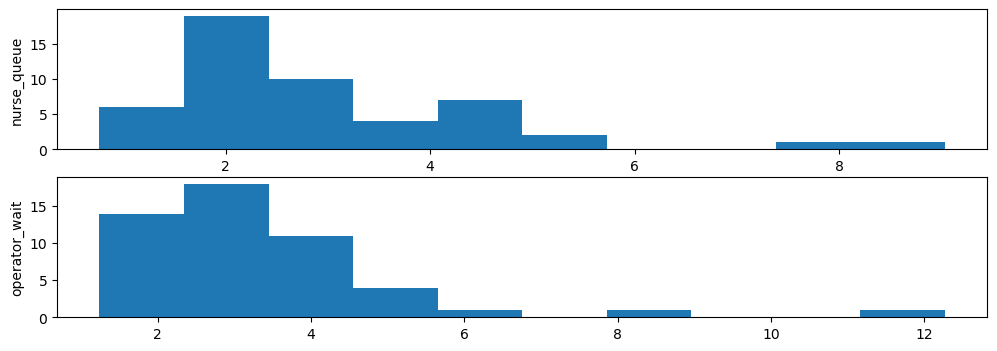

In [8]:
args = Scenario()

# run multiple replications.
# by default it runs 5 replications.
print('Running multiple replications', end=' => ')
results  = multiple_replications(args, n_reps=50)
print('done.\n')

fig, ax = plt.subplots(2, 1, figsize=(12,4))
ax[0].hist(results['nurse_queue']);
ax[0].set_ylabel('nurse_queue')
ax[1].hist(results['operator_wait']);
ax[1].set_ylabel('operator_wait');

In [9]:
def my_multiple_replications(scenario, rc_period=1440, warm_up=0, n_reps=5):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.  
        the number of minutes to run the model beyond warm up
        to collect results
    
    warm_up: float, optional (default=0)
        initial transient period.  no results are collected in this period

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.
        
    Returns:
    --------
    pandas.DataFrame
    '''
    # I have now set single_run's random_no_set parameter
    # this means that each replication has controlled reproducible sampling.
    results = [single_run(scenario, rc_period, warm_up, random_no_set=rep) 
               for rep in range(n_reps)]
    
    # format and return results in a dataframe
    df_results = pd.concat(results)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results


# default scenario
args = Scenario()

print('Running multiple replications', end=' => ')
results = my_multiple_replications(args, n_reps=5)
print('done.\n')
results

Running multiple replications => done.



,operator_wait,operator_queue,ops_util,nurse_wait,nurse_util,nurse_queue
rep,,,,,,
1,5.147623,9.663681,0.961942,4.079014,0.937849,3.344262
2,3.269568,6.170641,0.957109,4.158595,0.907009,3.455683
3,3.943983,7.349916,0.940515,6.465196,0.906577,5.095833
4,2.786155,5.253068,0.929235,2.615945,0.879775,2.259419
5,2.258900,4.307110,0.930750,2.357280,0.883779,1.994629


Running warm-up analysis with replications. Please wait... => done.


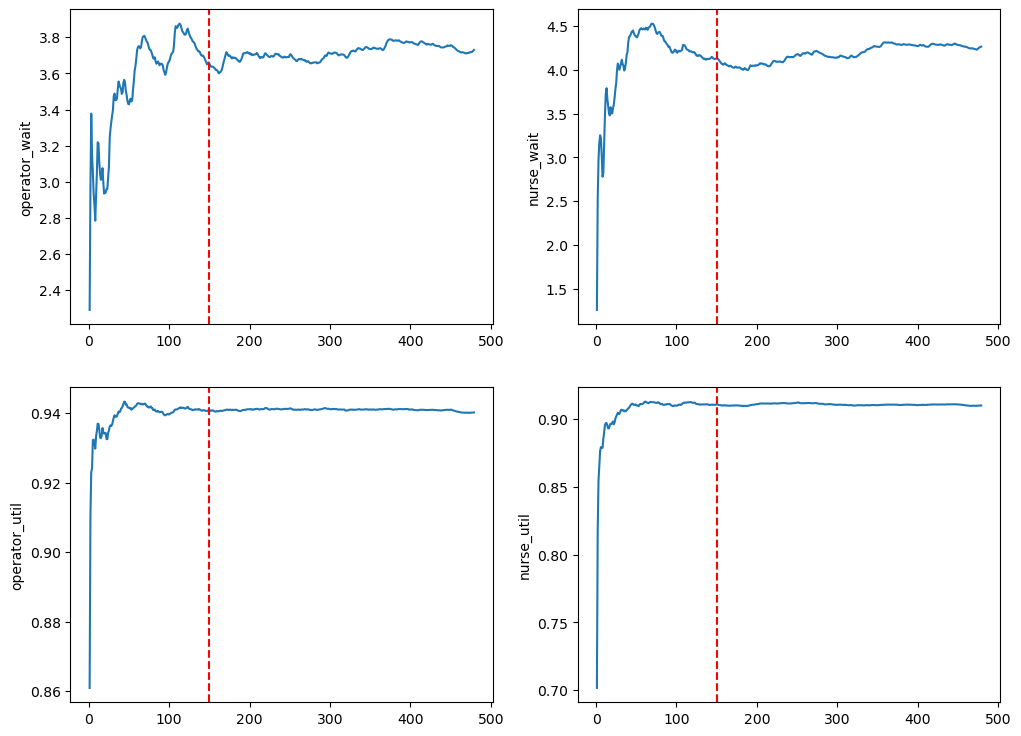

In [10]:
# script
# note this will take 5-30 seconds to run depending on your machine

# run for 40 days
RUN_LENGTH = 1440 * 40

# run at least 5 replications, but more might be needed for noisy data
N_REPS = 10

# default scenario
args = Scenario()

#run warm up analysis for scenario
print('Running warm-up analysis with replications. Please wait...', end=' => ')
results = warmup_analysis(args, rc_period=RUN_LENGTH, n_reps=N_REPS)
print('done.')

def time_series_inspection(results, warm_up=None):
    '''
    Time series inspection method
    
    Parameters:
    ----------
    results: dict
        The dict of results taken from warmup_analysis
    '''
    
    # create the 4 chart areas to plot
    fig, ax = plt.subplots(2, 2, figsize=(12,9))
    
    # take the mean of the columns for each metric and plot
    ax[0][0].plot(results['operator_wait'].mean(axis=1))
    ax[0][1].plot(results['nurse_wait'].mean(axis=1))
    ax[1][0].plot(results['operator_util'].mean(axis=1))
    ax[1][1].plot(results['nurse_util'].mean(axis=1))

    # set the label of each chart
    ax[0][0].set_ylabel('operator_wait')
    ax[0][1].set_ylabel('nurse_wait')
    ax[1][0].set_ylabel('operator_util')
    ax[1][1].set_ylabel('nurse_util')

    if warm_up is not None:
        #add warmup cut-off vertical line if one is specified
        ax[0][0].axvline(x=warm_up, color='red', ls='--')
        ax[0][1].axvline(x=warm_up, color='red', ls='--')
        ax[1][0].axvline(x=warm_up, color='red', ls='--')
        ax[1][1].axvline(x=warm_up, color='red', ls='--')
    
    return fig, ax


# this assumes you assigned the output of warmup_analysis to a varible 'results'
fig, ax = time_series_inspection(results, warm_up=150)

In [11]:
%%time 

############## MODIFICATION  ################################
# set models warmup period
AUDIT_INTERVAL = 120
# set this to the value you selected e.g. between 150 and 250
WARM_UP_INTERVALS = 170 
# this converts you warmup interval into minutes.
WARM_UP = WARM_UP_INTERVALS * AUDIT_INTERVAL
##############################################################

# results collection over a single day
RC_PERIOD = 1440

# number of replications
N_REPS = 80

# default scenario
args = Scenario()

# run multiple replications.
print('Running multiple replications', end=' => ')
replications  = multiple_replications(args, rc_period=RC_PERIOD, warm_up=WARM_UP,
                                      n_reps=N_REPS)
print('done.\n')

# show results summary rounded to 2dp
replications.describe().round(2)

Running multiple replications => done.

CPU times: user 695 ms, sys: 34.9 ms, total: 730 ms
Wall time: 14 s


,operator_wait,operator_queue,ops_util,nurse_wait,nurse_util,nurse_queue
count,80.00,80.00,80.00,80.00,80.00,80.00
mean,3.71,6.93,0.94,4.19,0.91,3.37
std,0.66,1.17,0.00,0.78,0.01,0.58
min,2.39,4.54,0.93,2.86,0.89,2.38
25%,3.37,6.31,0.94,3.67,0.90,2.96
50%,3.66,6.84,0.94,4.16,0.91,3.35
75%,3.89,7.24,0.94,4.58,0.91,3.66
max,7.16,13.03,0.95,7.09,0.92,5.47



minimum number of reps for 5% precision: 21



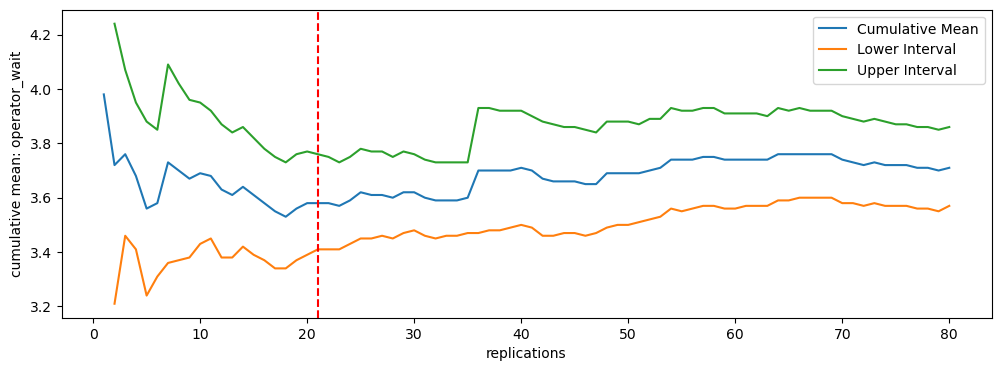

In [12]:
def confidence_interval_method(replications, alpha=0.05, desired_precision=0.05, 
                               min_rep=5, decimal_place=2):
    '''
    The confidence interval method for selecting the number of replications
    to run in a simulation.
    
    Finds the smallest number of replications where the width of the confidence
    interval is less than the desired_precision.  
    
    Returns both the number of replications and the full results dataframe.
    
    Parameters:
    ----------
    replications: arraylike
        Array (e.g. np.ndarray or list) of replications of a performance metric
        
    alpha: float, optional (default=0.05)
        procedure constructs a 100(1-alpha) confidence interval for the 
        cumulative mean.
        
    desired_precision: float, optional (default=0.05)
        Desired mean deviation from confidence interval.
        
    min_rep: int, optional (default=5)
        set to a integer > 0 and ignore all of the replications prior to it 
        when selecting the number of replications to run to achieve the desired
        precision.  Useful when the number of replications returned does not
        provide a stable precision below target.
        
    decimal_places: int, optional (default=2)
        sets the number of decimal places of the returned dataframe containing
        the results
    
    Returns:
    --------
        tuple: int, pd.DataFrame
    
    '''
    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]
    for i in range(1, n):
        cumulative_mean.append(cumulative_mean[i-1] + \
                       (replications[i] - cumulative_mean[i-1] ) / (i+1))
        
        # running biased variance
        running_var.append(running_var[i-1] + (replications[i] 
                                               - cumulative_mean[i-1]) \
                            * (replications[i] - cumulative_mean[i]))
        
    # unbiased std dev = running_var / (n - 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        running_std = np.sqrt(running_var / np.arange(n))
    
    # half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2),  dof)    
    with np.errstate(divide='ignore', invalid='ignore'):
        std_error = running_std / np.sqrt(np.arange(1, n+1))
        
    half_width = t_value * std_error
        
    # upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width
    
    # Mean deviation
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (half_width / cumulative_mean) * 100
    
    # commbine results into a single dataframe
    results = pd.DataFrame([replications, cumulative_mean, 
                            running_std, lower, upper, deviation]).T
    results.columns = ['Mean', 'Cumulative Mean', 'Standard Deviation', 
                       'Lower Interval', 'Upper Interval', '% deviation']
    results.index = np.arange(1, n+1)
    results.index.name = 'replications'
    
    # get the smallest no. of reps where deviation is less than precision target
    try:
        n_reps = results.iloc[min_rep:].loc[results['% deviation'] 
                             <= desired_precision*100].iloc[0].name
    except:
        # no replications with desired precision
        message = 'WARNING: the replications do not reach desired precision'
        warnings.warn(message)
        n_reps = -1 

    
    return n_reps, results.round(2)


# run the method on the operator_wait replications
n_reps, conf_ints = \
    confidence_interval_method(replications['operator_wait'].to_numpy(),
                               desired_precision=0.05)

# print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

# peek at table of results
conf_ints.head()


def plot_confidence_interval_method(n_reps, conf_ints, metric_name, 
                                    figsize=(12,4)):
    '''
    Plot the confidence intervals and cumulative mean
    
    Parameters:
    ----------
    n_reps: int
        minimum number of reps selected
        
    conf_ints: pandas.DataFrame
       results of the `confidence_interval_method` function
       
    metric_name: str
        Name of the performance measure
        
    figsize: tuple, optional (default=(12,4))
        The size of the plot
        
    Returns:
    -------
        matplotlib.pyplot.axis
    '''
    # plot cumulative mean + lower/upper intervals
    ax = conf_ints[['Cumulative Mean', 'Lower Interval', 
                         'Upper Interval']].plot(figsize=figsize)
    # add the 
    ax.axvline(x=n_reps, ls='--', color='red')
    
    ax.set_ylabel(f'cumulative mean: {metric_name}')
    
    return ax


# plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='operator_wait')

In [13]:
# quick check if the % deviation remains below 5% for the next 10 reps?
lookahead = 15
conf_ints.iloc[n_reps-1:n_reps+lookahead]

,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
21,3.67,3.58,0.41,3.41,3.76,4.95
22,3.48,3.58,0.40,3.41,3.75,4.73
23,3.37,3.57,0.39,3.41,3.73,4.56
24,4.01,3.59,0.39,3.43,3.75,4.46
25,4.29,3.62,0.41,3.45,3.78,4.51
26,3.40,3.61,0.40,3.45,3.77,4.37
27,3.74,3.61,0.40,3.46,3.77,4.21
28,3.26,3.60,0.40,3.45,3.75,4.13
29,4.09,3.62,0.40,3.47,3.77,4.07



minimum number of reps for 5% precision: 51



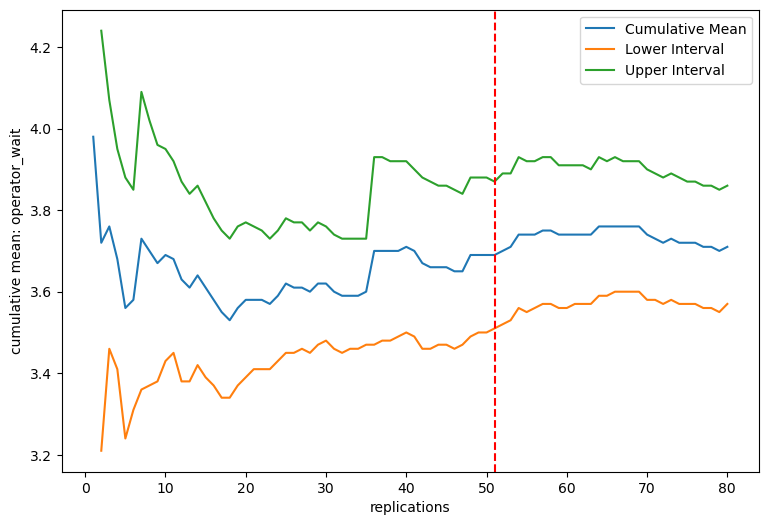

In [14]:
# run the method on the operator_wait replications
n_reps, conf_ints = \
    confidence_interval_method(replications['operator_wait'].to_numpy(),
                               desired_precision=0.05, min_rep=36)


# print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

# plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='operator_wait', figsize=(9,6))

Scenario Analysis
No. Scenario: 4
Replicatins: 51
Running base => done.

Running operator+1 => done.

Running nurse+1 => done.

Running operator+nurse => done.

Scenario analysis complete.


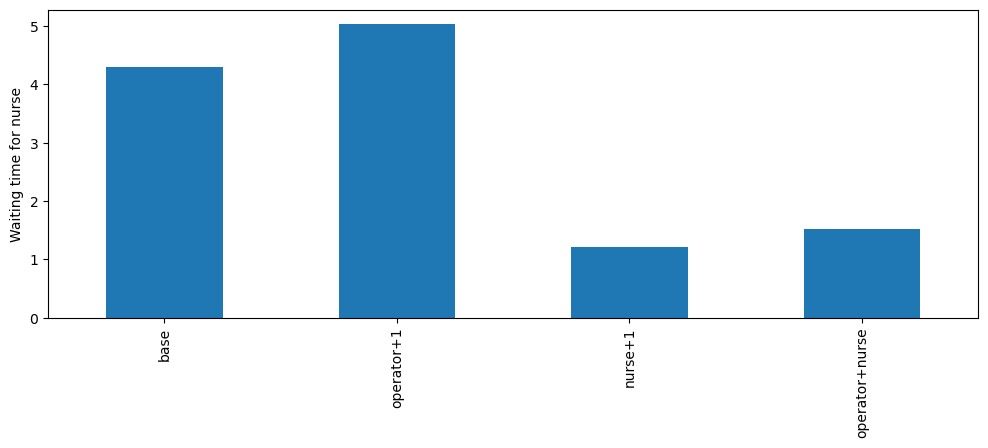

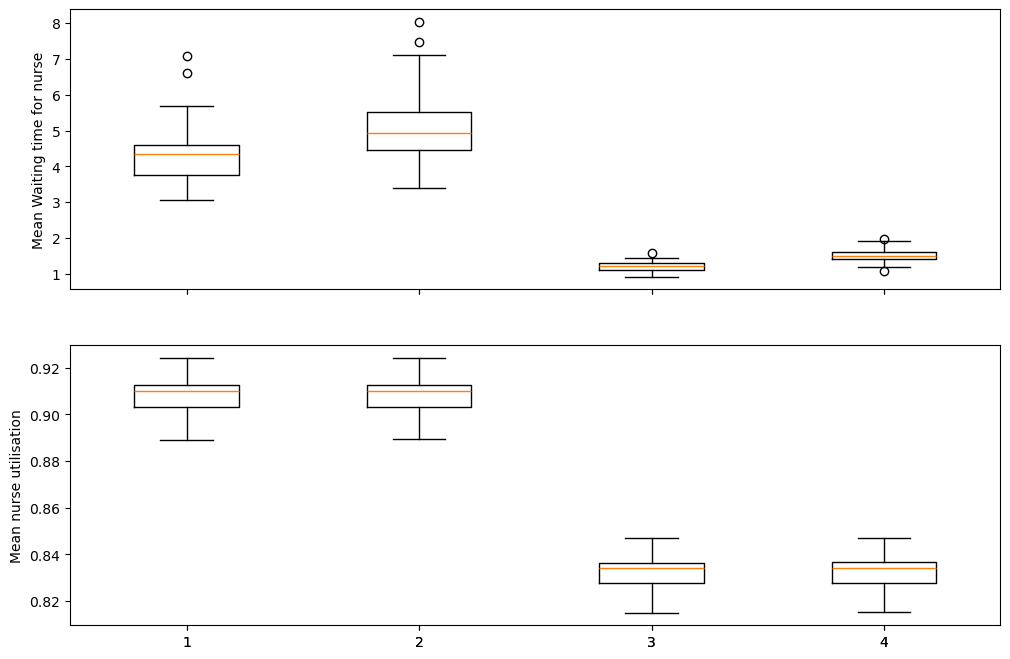

In [15]:
# example answer
def get_scenarios():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Returns:
    --------
    dict
        Contains the scenarios for the model
    '''
    scenarios = {}
    scenarios['base'] = Scenario()
    
    ########## MODIFICATION HERE ##########################
    # your code here...
    scenarios['operator+1'] = Scenario()
    scenarios['operator+1'].n_operators += 1
    
    scenarios['nurse+1'] = Scenario()
    scenarios['nurse+1'].n_nurses += 1
    
    scenarios['operator+nurse'] = Scenario()
    scenarios['operator+nurse'].n_operators += 1
    scenarios['operator+nurse'].n_nurses += 1
    
    #######################################################
    
    return scenarios


def run_scenario_analysis(scenarios, rc_period, warm_up, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period, warmup and replications.
    
    (note if you have lots of scenarios this may take several minutes)
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replicatins: {n_reps}')
    
    
    scenario_results = {}
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        replications  = multiple_replications(scenario, rc_period=RC_PERIOD, 
                                              warm_up=warm_up,
                                              n_reps=n_reps)
        print('done.\n')
        
        #save the results
        scenario_results[sc_name] = replications
    
    print('Scenario analysis complete.')
    return scenario_results


# script to run model
# note: for 4 scenarios and 50 reps this will take a few minutes.

# set models warmup period
AUDIT_INTERVAL = 120
# set this to the value you selected e.g. between 150 and 250
WARM_UP_INTERVALS = 170 
# this converts you warmup interval into minutes.
WARM_UP = WARM_UP_INTERVALS * AUDIT_INTERVAL

# results collection over a single day
RC_PERIOD = 1440

# number of replications
N_REPS = 51

# get the scenarios
scenarios = get_scenarios()

# run the scenario analysis
scenario_results = run_scenario_analysis(scenarios, RC_PERIOD, WARM_UP,
                                         N_REPS)


def scenario_summary_frame(scenario_results):
    '''
    Mean results for each performance measure by scenario
    
    Parameters:
    ----------
    scenario_results: dict
        dictionary of replications.  
        Key identifies the performance measure
        
    Returns:
    -------
    pd.DataFrame
    '''
    columns = []
    summary = pd.DataFrame()
    for sc_name, replications in scenario_results.items():
        summary = pd.concat([summary, replications.mean()], axis=1)
        columns.append(sc_name)

    summary.columns = columns
    return summary


summary_frame = scenario_summary_frame(scenario_results)

ax = summary_frame.T['nurse_wait'].plot.bar(figsize=(12,4))
ax.set_ylabel('Waiting time for nurse');


def metric_by_scenario(select, scenario_results):
    metric = pd.DataFrame()
    columns = []
    for sc_name, replications in scenario_results.items():
        metric = pd.concat([metric, replications[select]], 
                           axis=1)
        columns.append(sc_name)

    metric.columns = columns
    return metric


metric_nw = metric_by_scenario('nurse_wait', 
                               scenario_results)

metric_nu = metric_by_scenario('nurse_util',
                               scenario_results)

fig, ax = plt.subplots(2, 1, figsize=(12,8), 
                       sharex=True)
ax[0].boxplot(metric_nw);
ax[1].boxplot(metric_nu);
ax[0].set_ylabel('Mean Waiting time for nurse')
ax[1].set_ylabel('Mean nurse utilisation');